In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

I first read the data obtained with the Keck telescope into the frame data

In [2]:
newdata = pd.read_table('Keckdata.txt', skiprows=[0, 2], sep='\s+')

And I select the three important variables, with the option to add an error in quadrature

In [3]:
bjd = np.array(newdata['JD-2.44e6'], 'd')
rvs = np.array(newdata['mnvel'], 'd')
rverr = np.array(newdata['errvel'], 'd')
additionalerr = 0.0
error = np.sqrt(rverr**2+additionalerr**2)

Now I use the orbital ephemeris obtained from the transits to define the orbital phases, and I also define a new zero point for the BJD timestamps

In [4]:
period = 0.6892099
tc = 2454953.1910
tc = tc-2440000.0

phasesaux = (bjd-tc)/period
phases, orbit = np.modf(phasesaux)

phases = phases
bjdlv = np.mean(bjd)
bjdrest, bjdint = np.modf(bjdlv)

phi0 = (bjdint-tc)/period
aux, phi0 = phi0-np.modf(phi0)

shortbjd = bjd-bjdint

data = np.append(phases, shortbjd)

Now I define a function to fit a simple second order polynomial with time with the planet signal

In [5]:
def oneperiodplanet(x, K, a, Amp, Phi, Per):
    "Model to fit a sinusoid to the RV data"
    num = len(x)
    newphase = x[0:num/2]
    newbjd = x[num/2:]
    return -K*np.sin(2.0*np.pi*newphase) + a + Amp*np.sin(2.0*np.pi*(newbjd-Phi)/Per)

And I obtain the best fit parameters, their uncertainties, and I plot the observations and the model

In [14]:
params, conv = curve_fit(oneperiodplanet, data, rvs, sigma=error,p0=[3.0, 0.0, 0.0, 0.0, 30.0 ] )
paramserror = np.sqrt(np.diag(conv))

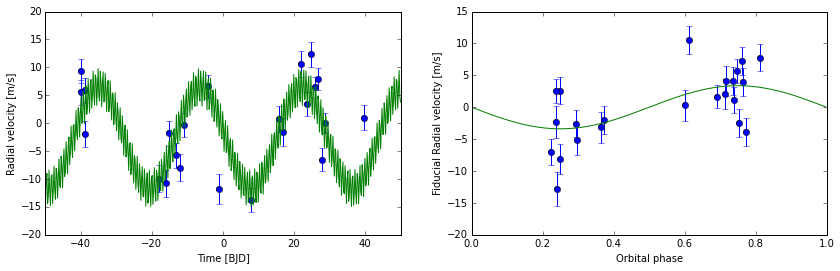

In [15]:
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(1,2,1)
ax.scatter(shortbjd, rvs)
ax.errorbar(shortbjd, rvs, yerr=error, fmt='o')
plt.xlim([-50, 50]) 
ax.set_xlabel('Time [BJD]')
ax.set_ylabel('Radial velocity [m/s]')

K, a, Amp, Phi, Per= params
Kerr, aerr, Amperr, Phierr, Pererr = paramserror

theoRV = oneperiodplanet(data, K, a, Amp, Phi, Per)
chi2= np.sum( ((theoRV-rvs)/error)**2)

newbjd = np.linspace(-50, 50, 500)
newx = (newbjd/period) + phi0
newphases, orbit = np.modf(newx)



newdata = np.append(newx, newbjd)

plt.plot(newbjd, oneperiodplanet(newdata, K, a, Amp, Phi, Per))


ax = fig.add_subplot(1,2,2)

plottheoRV = oneperiodplanet(data, 0.0, a,Amp, Phi, Per)

ax.scatter(phases, rvs-plottheoRV)
ax.errorbar(phases, rvs-plottheoRV, yerr=error, fmt='o')
plt.xlim([-0, 1]) 
ax.set_xlabel('Orbital phase')
ax.set_ylabel('Fiducial Radial velocity [m/s]')


sort_index = np.argsort(newphases)
ytheo = oneperiodplanet(newdata, K, 0.0, 0.0, 0.0, 1.0)

plt.plot(newphases[sort_index], ytheo[sort_index])

In [17]:
print('K value {0:3.2f} +- {1:3.2f}' .format(K, Kerr))
print('Chi2 value {0:3.2f} with {1:1.0f} points and 6 parameters' .format(chi2, len(rvs)))
print('First period {0:3.2f} +- {1:3.2f}'.format(Per, Pererr))

K value 3.38 +- 1.06
Chi2 value 82.54 with 23 points and 6 parameters
First period 28.63 +- 0.91
